In [1]:
import matplotlib.pyplot as plt
from SpatialAxis.spatial_axis import spatial_axis_to_labelmap
from SpatialAxis import spatial_axis
from SpatialAxis.utility import random_shapely_circles, create_broad_annotation_polygons
import geopandas
from rasterio.features import rasterize
import numpy as np
import numpy
import warnings
import scipy
import typing

2048


,geometry
0,"POLYGON ((785.718 243.383, 785.628 241.554, 78..."
1,"POLYGON ((1241.833 39.941, 1241.757 38.394, 12..."
2,"POLYGON ((136.961 221.741, 136.874 219.976, 13..."
3,"POLYGON ((1469.982 5.27, 1469.887 3.324, 1469...."
4,"POLYGON ((1720.752 54.359, 1720.675 52.799, 17..."
...,...
195,"POLYGON ((507.463 19.421, 507.387 17.888, 507...."
196,"POLYGON ((277.932 38.887, 277.856 37.349, 277...."
197,"POLYGON ((1329.24 46.561, 1329.159 44.922, 132..."
198,"POLYGON ((1854.96 121.334, 1854.872 119.537, 1..."


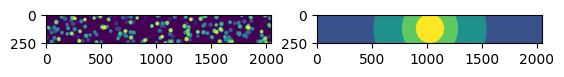

In [2]:
IMG_SHAPE = (256, 2048)

shapes = random_shapely_circles(
    image_shape=IMG_SHAPE, 
    num_circles=200,
    min_radius=15,
    max_radius=20,
    seed=42,
    )

labeled_polygons = [(polygon, idx + 1) for idx, polygon in enumerate(shapes)]
labeled_array = rasterize(
    [(poly, label) for poly, label in labeled_polygons], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

NUM_BROAD_ANNOTATION = 5

broad_annotations = create_broad_annotation_polygons(
    image_shape=IMG_SHAPE, 
    annotation_shape="circle",
    num_levels=NUM_BROAD_ANNOTATION,
    downscale_factor=0.5
    )
labeled_broad_annotations = [(polygon, idx + 1) for idx, polygon in enumerate(broad_annotations)]
labeled_broad_annotations = rasterize(
    [(poly, label) for poly, label in labeled_broad_annotations], 
    out_shape=IMG_SHAPE,
    fill=0,  # Background value
)

fig, ax = plt.subplots(1, 2)
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)

shapes = geopandas.GeoDataFrame(geometry=shapes)
broad_df = geopandas.GeoDataFrame(
    {
        "geometry": broad_annotations,
        "broad_annotation_id": np.arange(NUM_BROAD_ANNOTATION),
    }
)
broad_df = broad_df.set_index("broad_annotation_id")
shapes

In [3]:
shapes["spatial_axis"] = spatial_axis(
    shapes,
    broad_df,
    np.arange(NUM_BROAD_ANNOTATION),
    k_neighbours=5
)

shapes

,geometry,spatial_axis
0,"POLYGON ((785.718 243.383, 785.628 241.554, 78...",0.515328
1,"POLYGON ((1241.833 39.941, 1241.757 38.394, 12...",0.814442
2,"POLYGON ((136.961 221.741, 136.874 219.976, 13...",-0.228520
3,"POLYGON ((1469.982 5.27, 1469.887 3.324, 1469....",0.271349
4,"POLYGON ((1720.752 54.359, 1720.675 52.799, 17...",-0.363170
...,...,...
195,"POLYGON ((507.463 19.421, 507.387 17.888, 507....",-0.262096
196,"POLYGON ((277.932 38.887, 277.856 37.349, 277....",-0.315218
197,"POLYGON ((1329.24 46.561, 1329.159 44.922, 132...",0.389945
198,"POLYGON ((1854.96 121.334, 1854.872 119.537, 1...",-0.410556


In [4]:
np.floor(shapes["geometry"].iloc[0].centroid.coords[0])[::-1]

array([243., 767.])

[(-0.5, 2047.5, 255.5, -0.5),
 (-0.5, 2047.5, 255.5, -0.5),
 (-0.5, 2047.5, 255.5, -0.5)]

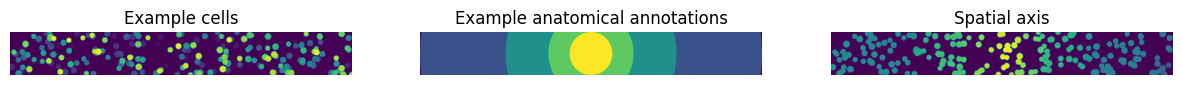

In [5]:
relative_array = spatial_axis_to_labelmap(
    shapes,
    IMG_SHAPE,
    background_value=-2
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)
ax[2].imshow(relative_array)

ax[0].set_title("Example cells")
ax[1].set_title("Example anatomical annotations")
ax[2].set_title("Spatial axis")

[_ax.axis("off") for _ax in ax.flatten()]

# Use a label array to define broad annotations

In [7]:
shapes["spatial_axis"] = spatial_axis(
    shapes,
    labeled_broad_annotations,
    np.arange(NUM_BROAD_ANNOTATION),
    k_neighbours=5
)

shapes

,geometry,spatial_axis
0,"POLYGON ((785.718 243.383, 785.628 241.554, 78...",0.819012
1,"POLYGON ((1241.833 39.941, 1241.757 38.394, 12...",1.394083
2,"POLYGON ((136.961 221.741, 136.874 219.976, 13...",-0.138232
3,"POLYGON ((1469.982 5.27, 1469.887 3.324, 1469....",0.519975
4,"POLYGON ((1720.752 54.359, 1720.675 52.799, 17...",-0.228177
...,...,...
195,"POLYGON ((507.463 19.421, 507.387 17.888, 507....",-0.088937
196,"POLYGON ((277.932 38.887, 277.856 37.349, 277....",-0.201076
197,"POLYGON ((1329.24 46.561, 1329.159 44.922, 132...",0.849121
198,"POLYGON ((1854.96 121.334, 1854.872 119.537, 1...",-0.303900


[(-0.5, 2047.5, 255.5, -0.5),
 (-0.5, 2047.5, 255.5, -0.5),
 (-0.5, 2047.5, 255.5, -0.5)]

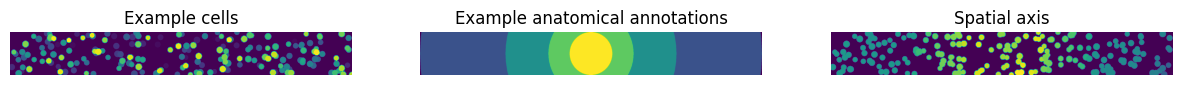

In [8]:
relative_array = spatial_axis_to_labelmap(
    shapes,
    IMG_SHAPE,
    background_value=-2
)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(labeled_array)
ax[1].imshow(labeled_broad_annotations)
ax[2].imshow(relative_array)

ax[0].set_title("Example cells")
ax[1].set_title("Example anatomical annotations")
ax[2].set_title("Spatial axis")

[_ax.axis("off") for _ax in ax.flatten()]